In [1]:
import sys
import os

# Go up to project root (from inside training/)
project_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
import numpy as np
import torch
import torch.nn as nn
import gc
import random
from core.models.hierarchical_transformer import HierarchicalTransformer
from core.utils import create_transformer_dataset, generate_model_filename
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import os


In [3]:
def initial_cleanup():
    # Memory cleanup
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
    gc.collect()
    
    # Set random seeds
    random.seed(69)
    np.random.seed(69)
    torch.manual_seed(69)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(69)
        torch.cuda.manual_seed_all(69)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    print("Clean slate initialized!")

# Call this at the top of your notebook
initial_cleanup()

Clean slate initialized!


In [5]:
X_np, y_np, attention_masks_np, sequence_lengths_np = create_transformer_dataset(data_dir="../../data/keypoints",verbose=False)

Using max_frames = 200 (95.0th percentile)
Sequence length stats - Min: 0, Max: 404
Filtering out sample with length 236
Filtering out sample with length 236
Filtering out sample with length 267
Filtering out sample with length 267
Filtering out sample with length 237
Filtering out sample with length 237
Filtering out sample with length 248
Filtering out sample with length 248
Filtering out sample with length 207
Filtering out sample with length 207
Filtering out sample with length 219
Filtering out sample with length 219
Filtering out sample with length 280
Filtering out sample with length 280
Filtering out sample with length 249
Filtering out sample with length 249
Filtering out sample with length 247
Filtering out sample with length 247
Filtering out sample with length 210
Filtering out sample with length 210
Filtering out sample with length 215
Filtering out sample with length 215
Filtering out sample with length 283
Filtering out sample with length 283
Filtering out sample with le

In [6]:
# Convert to PyTorch tensors
X_np = X_np[:, :, :, :3]  # drop visibility
X_tensor = torch.from_numpy(X_np).float() # Assuming keypoints are floats
y_tensor = torch.from_numpy(y_np).long()  # Labels should be long for CrossEntropyLoss
attention_masks_tensor = torch.from_numpy(attention_masks_np).float()


X_temp, X_test, y_temp, y_test, mask_temp, mask_test = train_test_split(
    X_tensor, y_tensor, attention_masks_tensor, 
    test_size=0.1, random_state=69
)

val_ratio = 0.1 / 0.9  # ≈ 0.1111 of remaining
X_train, X_val, y_train, y_val, mask_train, mask_val = train_test_split(
    X_temp, y_temp, mask_temp, 
    test_size=val_ratio, random_state=69
)

# Create dataloaders with temporal masks included
train_dataset = TensorDataset(X_train, y_train, mask_train)
val_dataset = TensorDataset(X_val, y_val, mask_val)
test_dataset = TensorDataset(X_test, y_test, mask_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

In [7]:
parameters = dict(
    num_joints=33,
    num_frames=200,
    d_model=64,
    nhead=4,
    num_spatial_layers=1,
    num_temporal_layers=1,
    num_classes=3,
    dim_feedforward=512,
    dropout=0.1
)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = HierarchicalTransformer(**parameters).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [10]:
num_epochs = 30
train_loss_history = []
val_loss_history = []

train_acc_history = []
val_acc_history = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct = 0

    for X_batch, y_batch, mask_batch in train_loader:
        
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        mask_batch = mask_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x=X_batch, temporal_mask=mask_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X_batch.size(0)
        correct += (outputs.argmax(1) == y_batch).sum().item()

    train_loss /= len(train_loader.dataset)
    train_acc = correct / len(train_loader.dataset)
    
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

     # ---------- VALIDATION ----------
    model.eval()
    val_loss = 0
    val_correct = 0
    with torch.no_grad():
        for X_batch, y_batch, mask_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            mask_batch = mask_batch.to(device)
            
            outputs = model(x=X_batch, temporal_mask=mask_batch)
            loss = criterion(outputs, y_batch)
            
            

            val_loss += loss.item() * X_batch.size(0)
            val_correct += (outputs.argmax(1) == y_batch).sum().item()

    val_loss /= len(val_loader.dataset)
    val_acc = val_correct / len(val_loader.dataset)
    
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

d:\Thesis\thesis\Lib\site-packages\torch\nn\modules\transformer.py:505: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\NestedTensorImpl.cpp:182.)
  output = torch._nested_tensor_from_mask(


Epoch 1/30 | Train Loss: 1.0282, Acc: 0.4988 | Val Loss: 0.9005, Acc: 0.5519
Epoch 2/30 | Train Loss: 0.6360, Acc: 0.7761 | Val Loss: 0.4170, Acc: 0.8349
Epoch 3/30 | Train Loss: 0.3531, Acc: 0.9094 | Val Loss: 0.2566, Acc: 0.9245
Epoch 4/30 | Train Loss: 0.2619, Acc: 0.9242 | Val Loss: 0.2068, Acc: 0.9292
Epoch 5/30 | Train Loss: 0.2056, Acc: 0.9378 | Val Loss: 0.1815, Acc: 0.9528
Epoch 6/30 | Train Loss: 0.1836, Acc: 0.9449 | Val Loss: 0.1712, Acc: 0.9434
Epoch 7/30 | Train Loss: 0.1662, Acc: 0.9485 | Val Loss: 0.1684, Acc: 0.9528
Epoch 8/30 | Train Loss: 0.1574, Acc: 0.9544 | Val Loss: 0.1861, Acc: 0.9198
Epoch 9/30 | Train Loss: 0.1348, Acc: 0.9573 | Val Loss: 0.2355, Acc: 0.9151
Epoch 10/30 | Train Loss: 0.1336, Acc: 0.9597 | Val Loss: 0.1496, Acc: 0.9481
Epoch 11/30 | Train Loss: 0.1246, Acc: 0.9562 | Val Loss: 0.1503, Acc: 0.9575
Epoch 12/30 | Train Loss: 0.1174, Acc: 0.9639 | Val Loss: 0.2063, Acc: 0.9151
Epoch 13/30 | Train Loss: 0.1102, Acc: 0.9621 | Val Loss: 0.1525, Acc: 0.

In [11]:
# Switch to eval mode
model.eval()

# Collect all predictions and true labels
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch, mask_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        mask_batch = mask_batch.to(device)

        # If your model uses the mask in forward()
        outputs = model(X_batch, mask_batch)

        preds = outputs.argmax(1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

# Generate classification report
report = classification_report(all_labels, all_preds, target_names=['squats', 'deadlifts', 'shoulder_press'])
print(report)

                precision    recall  f1-score   support

        squats       0.97      0.99      0.98        86
     deadlifts       0.98      0.98      0.98        55
shoulder_press       0.97      0.94      0.96        71

      accuracy                           0.97       212
     macro avg       0.97      0.97      0.97       212
  weighted avg       0.97      0.97      0.97       212



[[85  0  1]
 [ 0 54  1]
 [ 3  1 67]]


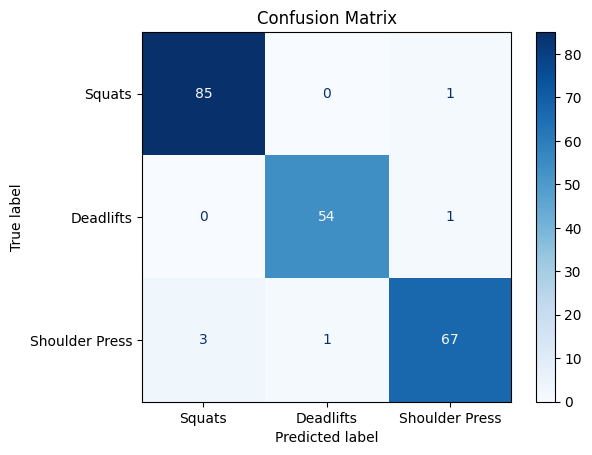

In [12]:
matrix = confusion_matrix(all_labels, all_preds)
print(matrix)

class_names = ['Squats', 'Deadlifts', 'Shoulder Press']

ConfusionMatrixDisplay.from_predictions(all_labels, all_preds,
                                        display_labels=class_names,
                                        cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

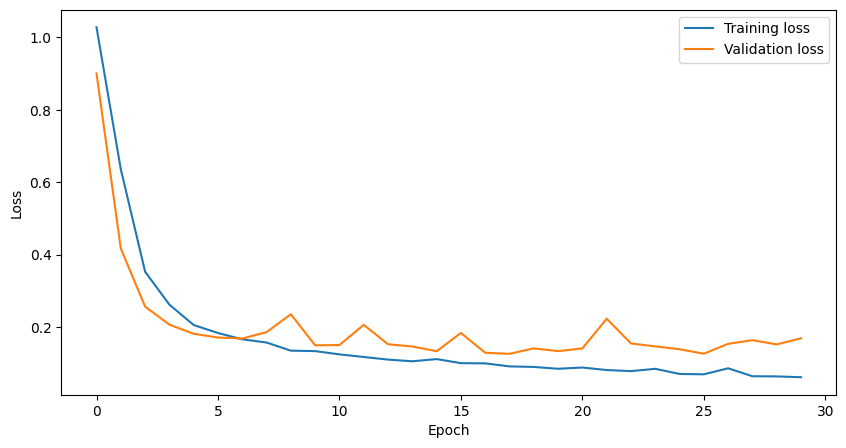

In [13]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label='Training loss')
plt.plot(val_loss_history, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

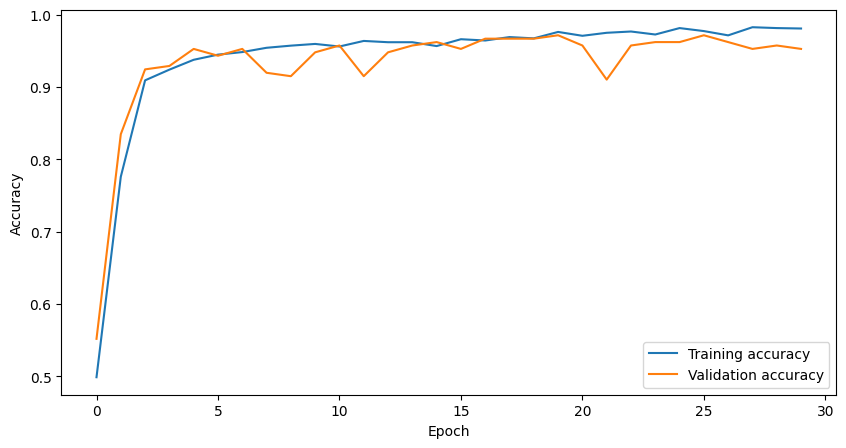

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(train_acc_history, label='Training accuracy')
plt.plot(val_acc_history, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Save model to disk
# OLD
# torch.save(model.state_dict(), '../../models/hierarchical transformer/hierarchical_transformer_v2_weights_2025-06-23_complete.pth')

In [18]:
model_name = "hierarchical_transformer"
filename = generate_model_filename(base_name=model_name, params=parameters)
# Save
save_path = os.path.join("../../models", model_name, filename)
os.makedirs(os.path.dirname(save_path), exist_ok=True)
torch.save(model.state_dict(), save_path)
